# 타이타닉 데이터 이진분류 정확도 경시대회
- Seaborn titanic data : 전처리는 ML에서 했던대로 할 것
- random seed = 2022
- train_test_split : test_size = 0.2
- validation_split = 0.2

신경망을 사용해서 정확도를 도출  
모델 정의/설정/실행/학습 --> 임의로 결정

파일 이름 : 이름 0.8934.html의 형식으로

# 1. 필요한 모듈 불러오기 및 데이터 로딩

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# 관습적으로 쓰기도 한다
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [151]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 2. 데이터 전처리

### 1) 필요한 컬럼 추리기

In [152]:
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'deck']]
df.head(6)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,NaN
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,NaN
5,0,3,male,NaN,0,0,8.4583,Q,NaN


### 2) 결측값 확인 및 처리

In [153]:
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
deck        688
dtype: int64

#### embarked의 경우 최빈값으로 대체

In [154]:
df['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [155]:
df['embarked'].fillna('S', inplace=True)
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      0
deck        688
dtype: int64

#### age의 경우 평균값(소수 첫째자리)으로 대체

In [156]:
round(df['age'].mean(), 1)

29.7

In [157]:
df['age'].fillna(round(df['age'].mean(), 1), inplace=True)
df.head(6)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,NaN
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,NaN
5,0,3,male,29.7,0,0,8.4583,Q,NaN


#### deck 컬럼의 경우 결측치가 너무 많으므로 삭제

In [158]:
df.drop(columns=['deck'], inplace=True)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 3) 데이터 인코딩 및 스케일링

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### 'sex' , 'embarked' 컬럼의 경우 카테고리 값이므로 레이블 인코딩 실시

In [160]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['sex'])
df['sex'] = le.transform(df['sex'])

df['embarked'] = le.fit_transform(df['embarked'])
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


#### X, y값을 설정

In [161]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

#### X의 각 컬럼 범위 분포가 서로 다르므로 정규화 스케일링 실시

In [162]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

# 3. Train/Test 분리

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, stratify = y, test_size = 0.2, random_state = 2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

# 4. Model 설정

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [240]:
model = Sequential([
                    Dense(64, input_dim = 7, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 64)                512       
                                                                 
 dense_297 (Dense)           (None, 32)                2080      
                                                                 
 dense_298 (Dense)           (None, 16)                528       
                                                                 
 dense_299 (Dense)           (None, 8)                 136       
                                                                 
 dense_300 (Dense)           (None, 4)                 36        
                                                                 
 dense_301 (Dense)           (None, 1)                 5         
                                                                 
Total params: 3,297
Trainable params: 3,297
Non-train

In [241]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.2, batch_size=50, epochs=200,
                 verbose = 1, callbacks = [checkpoint])

Epoch 1/200
 1/12 [=>............................] - ETA: 5s - loss: 0.7089 - accuracy: 0.6000
Epoch 00001: val_loss did not improve from 0.53542
12/12 [==============================] - 1s 18ms/step - loss: 0.6789 - accuracy: 0.6327 - val_loss: 0.6706 - val_accuracy: 0.6014
Epoch 2/200
 1/12 [=>............................] - ETA: 0s - loss: 0.6373 - accuracy: 0.7400
Epoch 00002: val_loss did not improve from 0.53542
12/12 [==============================] - 0s 6ms/step - loss: 0.6420 - accuracy: 0.6801 - val_loss: 0.6381 - val_accuracy: 0.6993
Epoch 3/200
 1/12 [=>............................] - ETA: 0s - loss: 0.6444 - accuracy: 0.5800
Epoch 00003: val_loss did not improve from 0.53542
12/12 [==============================] - 0s 3ms/step - loss: 0.5985 - accuracy: 0.7311 - val_loss: 0.5999 - val_accuracy: 0.7483
Epoch 4/200
 1/12 [=>............................] - ETA: 0s - loss: 0.5784 - accuracy: 0.7800
Epoch 00004: val_loss did not improve from 0.53542
12/12 [=====================

In [242]:
import os
if not os.path.exists('model'):
    os.mkdir('model')

In [243]:
# model_path = 'model/best_titanic.h5'
model_path = 'model/titanic_{epoch:03d}_{val_loss:.4f}.h5'

In [244]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path, monitor = 'val_loss', save_best_only=True
)

# ModelCheckpoint(모델 저장경로, 모델 저장시 기준값, save_best_only여부)

# 5. Model 평가 및 학습과정 시각화

In [245]:
from tensorflow.keras.models import load_model
best_model_path = 'model/titanic_023_0.4565.h5'
best_model = load_model(best_model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4031 - accuracy: 0.8268


[0.40310925245285034, 0.826815664768219]

In [246]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

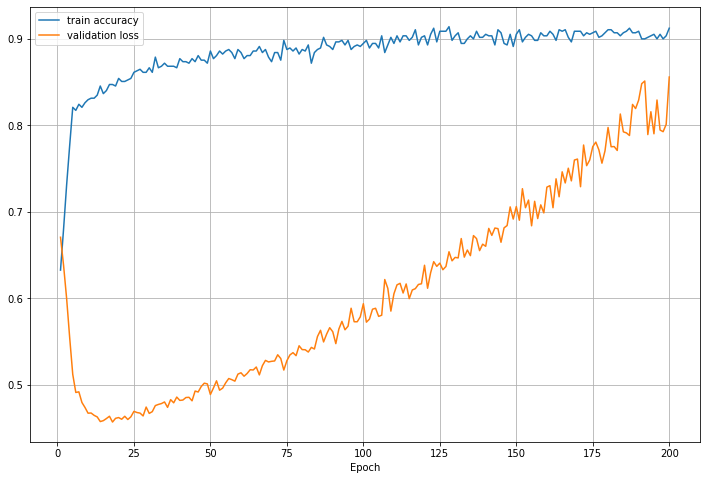

In [247]:
plt.figure(figsize=(12, 8))
plt.plot(xs, y_acc, ms=5, label = 'train accuracy')
plt.plot(xs, y_vloss, ms=5, label = 'validation loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.show()

# 다른 모델 반복

In [248]:
model2 = Sequential([
                    Dense(512, input_dim = 7, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_302 (Dense)           (None, 512)               4096      
                                                                 
 dense_303 (Dense)           (None, 256)               131328    
                                                                 
 dense_304 (Dense)           (None, 128)               32896     
                                                                 
 dense_305 (Dense)           (None, 64)                8256      
                                                                 
 dense_306 (Dense)           (None, 32)                2080      
                                                                 
 dense_307 (Dense)           (None, 1)                 33        
                                                                 
Total params: 178,689
Trainable params: 178,689
Non-t

In [249]:
model_path2 = 'model/best_titanic.h5'
# model_path = 'model/titanic_{epoch:03d}_{val_loss:.4f}.h5'

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path2, monitor = 'val_loss', save_best_only=True, verbose = 1
)


In [250]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 40)

In [251]:
model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist2 = model2.fit(X_train, y_train, batch_size = 200, epochs = 400, validation_split=0.2,
                   verbose = 0, callbacks = [checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.63820, saving model to model/best_titanic.h5

Epoch 00002: val_loss improved from 0.63820 to 0.56328, saving model to model/best_titanic.h5

Epoch 00003: val_loss improved from 0.56328 to 0.50892, saving model to model/best_titanic.h5

Epoch 00004: val_loss did not improve from 0.50892

Epoch 00005: val_loss did not improve from 0.50892

Epoch 00006: val_loss improved from 0.50892 to 0.47558, saving model to model/best_titanic.h5

Epoch 00007: val_loss improved from 0.47558 to 0.45558, saving model to model/best_titanic.h5

Epoch 00008: val_loss improved from 0.45558 to 0.44630, saving model to model/best_titanic.h5

Epoch 00009: val_loss did not improve from 0.44630

Epoch 00010: val_loss did not improve from 0.44630

Epoch 00011: val_loss did not improve from 0.44630

Epoch 00012: val_loss did not improve from 0.44630

Epoch 00013: val_loss did not improve from 0.44630

Epoch 00014: val_loss did not improve from 0.44630

Epoch 00015: val_

In [252]:
best_model2 = load_model(model_path2)
best_model2.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4030 - accuracy: 0.8380


[0.4030461311340332, 0.8379888534545898]

In [253]:
model3 = Sequential([
                    Dense(512, input_dim = 7, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_308 (Dense)           (None, 512)               4096      
                                                                 
 dense_309 (Dense)           (None, 256)               131328    
                                                                 
 dense_310 (Dense)           (None, 128)               32896     
                                                                 
 dense_311 (Dense)           (None, 64)                8256      
                                                                 
 dense_312 (Dense)           (None, 32)                2080      
                                                                 
 dense_313 (Dense)           (None, 16)                528       
                                                                 
 dense_314 (Dense)           (None, 1)               

In [254]:
model_path3 = 'model/best_titanic3.h5'
# model_path = 'model/titanic_{epoch:03d}_{val_loss:.4f}.h5'

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path3, monitor = 'val_loss', save_best_only=True, verbose = 1
)


In [255]:
model3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist3 = model3.fit(X_train, y_train, batch_size = 200, epochs = 400, validation_split=0.2,
                   verbose = 0, callbacks = [checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.65078, saving model to model/best_titanic3.h5

Epoch 00002: val_loss improved from 0.65078 to 0.59271, saving model to model/best_titanic3.h5

Epoch 00003: val_loss improved from 0.59271 to 0.52651, saving model to model/best_titanic3.h5

Epoch 00004: val_loss improved from 0.52651 to 0.49144, saving model to model/best_titanic3.h5

Epoch 00005: val_loss did not improve from 0.49144

Epoch 00006: val_loss did not improve from 0.49144

Epoch 00007: val_loss improved from 0.49144 to 0.47811, saving model to model/best_titanic3.h5

Epoch 00008: val_loss improved from 0.47811 to 0.46063, saving model to model/best_titanic3.h5

Epoch 00009: val_loss improved from 0.46063 to 0.45279, saving model to model/best_titanic3.h5

Epoch 00010: val_loss did not improve from 0.45279

Epoch 00011: val_loss did not improve from 0.45279

Epoch 00012: val_loss did not improve from 0.45279

Epoch 00013: val_loss did not improve from 0.45279

Epoch 00014: val_lo

In [256]:
best_model3 = load_model(model_path3)
best_model3.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8380


[0.40110528469085693, 0.8379888534545898]

In [257]:
model4 = Sequential([
                    Dense(64, input_dim = 7, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model4.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_315 (Dense)           (None, 64)                512       
                                                                 
 dense_316 (Dense)           (None, 32)                2080      
                                                                 
 dense_317 (Dense)           (None, 16)                528       
                                                                 
 dense_318 (Dense)           (None, 8)                 136       
                                                                 
 dense_319 (Dense)           (None, 4)                 36        
                                                                 
 dense_320 (Dense)           (None, 1)                 5         
                                                                 
Total params: 3,297
Trainable params: 3,297
Non-train

In [258]:
model_path4 = 'model/best_titanic4.h5'
# model_path = 'model/titanic_{epoch:03d}_{val_loss:.4f}.h5'

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path4, monitor = 'val_loss', save_best_only=True, verbose = 1
)


In [259]:
model4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist4 = model4.fit(X_train, y_train, batch_size = 200, epochs = 400, validation_split=0.2,
                   verbose = 0, callbacks = [checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.68219, saving model to model/best_titanic4.h5

Epoch 00002: val_loss improved from 0.68219 to 0.67413, saving model to model/best_titanic4.h5

Epoch 00003: val_loss improved from 0.67413 to 0.66590, saving model to model/best_titanic4.h5

Epoch 00004: val_loss improved from 0.66590 to 0.65787, saving model to model/best_titanic4.h5

Epoch 00005: val_loss improved from 0.65787 to 0.64924, saving model to model/best_titanic4.h5

Epoch 00006: val_loss improved from 0.64924 to 0.64016, saving model to model/best_titanic4.h5

Epoch 00007: val_loss improved from 0.64016 to 0.63041, saving model to model/best_titanic4.h5

Epoch 00008: val_loss improved from 0.63041 to 0.61982, saving model to model/best_titanic4.h5

Epoch 00009: val_loss improved from 0.61982 to 0.60832, saving model to model/best_titanic4.h5

Epoch 00010: val_loss improved from 0.60832 to 0.59594, saving model to model/best_titanic4.h5

Epoch 00011: val_loss improved from 0.59594

In [260]:
best_model4 = load_model(model_path4)
best_model4.evaluate(X_test, y_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.4148 - accuracy: 0.8212


[0.4148090183734894, 0.8212290406227112]

In [261]:
model5 = Sequential([
                    Dense(512, input_dim = 7, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model5.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_321 (Dense)           (None, 512)               4096      
                                                                 
 dense_322 (Dense)           (None, 256)               131328    
                                                                 
 dense_323 (Dense)           (None, 128)               32896     
                                                                 
 dense_324 (Dense)           (None, 64)                8256      
                                                                 
 dense_325 (Dense)           (None, 32)                2080      
                                                                 
 dense_326 (Dense)           (None, 16)                528       
                                                                 
 dense_327 (Dense)           (None, 8)               

In [262]:
model_path5 = 'model/best_titanic5.h5'
# model_path = 'model/titanic_{epoch:03d}_{val_loss:.4f}.h5'

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path5, monitor = 'val_loss', save_best_only=True, verbose = 1
)


In [263]:
model5.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist5 = model5.fit(X_train, y_train, batch_size = 200, epochs = 400, validation_split=0.2,
                   verbose = 0, callbacks = [checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.67376, saving model to model/best_titanic5.h5

Epoch 00002: val_loss improved from 0.67376 to 0.64163, saving model to model/best_titanic5.h5

Epoch 00003: val_loss improved from 0.64163 to 0.59676, saving model to model/best_titanic5.h5

Epoch 00004: val_loss improved from 0.59676 to 0.54534, saving model to model/best_titanic5.h5

Epoch 00005: val_loss improved from 0.54534 to 0.50889, saving model to model/best_titanic5.h5

Epoch 00006: val_loss improved from 0.50889 to 0.50808, saving model to model/best_titanic5.h5

Epoch 00007: val_loss improved from 0.50808 to 0.50172, saving model to model/best_titanic5.h5

Epoch 00008: val_loss improved from 0.50172 to 0.46879, saving model to model/best_titanic5.h5

Epoch 00009: val_loss did not improve from 0.46879

Epoch 00010: val_loss improved from 0.46879 to 0.45589, saving model to model/best_titanic5.h5

Epoch 00011: val_loss improved from 0.45589 to 0.45359, saving model to model/best_tita

In [264]:
best_model5 = load_model(model_path5)
best_model5.evaluate(X_test, y_test)

6/6 [==============================] - 1s 2ms/step - loss: 0.4145 - accuracy: 0.8492


[0.4145016372203827, 0.8491619825363159]

In [265]:
y_acc = hist5.history['accuracy']
y_vloss = hist5.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

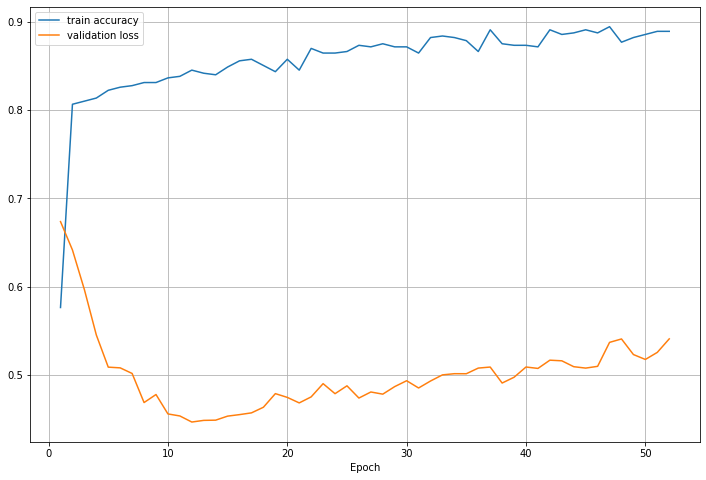

In [266]:
plt.figure(figsize=(12, 8))
plt.plot(xs, y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label = 'validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()